In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from rl_algos.ppo_continuous import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 512
num_updates = 3000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [4]:
single_train = jit(PPO_make_train(config), static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    # batchsize, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 3000 Updates
global update: 100
reward: -146.57782247848212
max pF: 2.5253136357059445
max photon: 30.72699609771371
photon time: 0.8013310200741781
smoothness: 0.004047764788710292
global update: 200
reward: -80.28672553876488
max pF: 2.55730284239534
max photon: 39.47179866582155
photon time: 0.7800985984227036
smoothness: 0.002474116490058965
global update: 300
reward: -35.41559025522566
max pF: 2.56096785139144
max photon: 40.76890539377928
photon time: 0.6846559815259479
smoothness: 0.0014276209857026195
global update: 400
reward: -3.1614456578907655
max pF: 2.556641957722416
max photon: 39.88225677609444
photon time: 0.4022511049681634
smoothness: 0.0007486067928196242
global update: 500
reward: 9.084765868457595
max pF: 2.5601122541360084
max photon: 40.28799131512642
photon time: 0.36940442225105247
smoothness: 0.00047809320557700027
global update: 600
reward: 17.19311969345584
max pF: 2.5597882084029653
max photon: 40.41492985188961
photon time: 0.35708132639

In [5]:
# Extracting Results

metrics = single_result["metrics"]

rewards = metrics["reward"]
max_pFs = metrics["max pF"]
max_photons = metrics["max photon"]
photon_times = metrics["photon time"]
smoothnesses = metrics["smoothness"]
actions = metrics["action"]

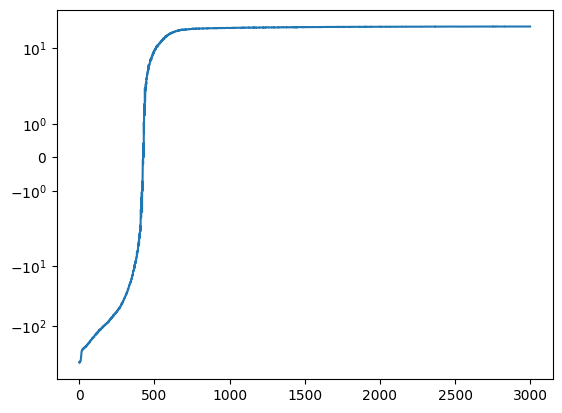

In [15]:
ppo_rewards = jnp.mean(rewards, axis=-1)
ppo_actions = jnp.mean(actions)
plt.plot(ppo_rewards)
plt.yscale('symlog')
plt.show()

(3000, 512, 121)


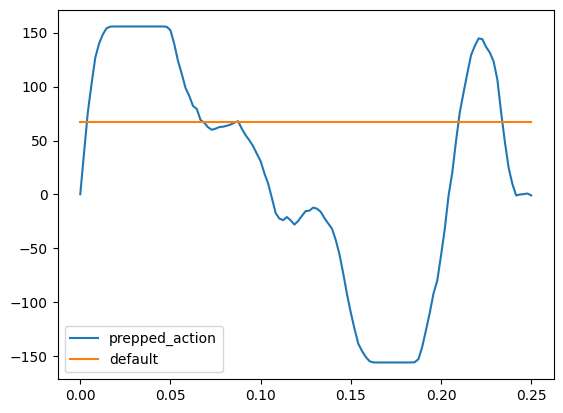

In [21]:
print(actions.shape)
opt_action = jnp.mean(actions, axis=1)[-1]
smooth_action = env.drive_smoother(opt_action)
prepped_action = env.prepare_action(opt_action)
plt.plot(env.ts_action, prepped_action, label='prepped_action')
plt.plot(env.ts_action, env.a0 * jnp.ones_like(env.ts_action), label='default')
plt.legend()
plt.show()

In [4]:
from evosax import CMA_ES, SimAnneal

In [5]:
## Initialising Environment

from rl_algos.rl_wrappers import VecEnv
from envs.single_photon_env import SinglePhotonLangevinReadoutEnv

env = SinglePhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    # batchsize=batchsize,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)
vec_env = VecEnv(env)

In [14]:
# Instantiate the search strategies

# CMA-ES
rng = jax.random.PRNGKey(0)
cma_strategy = CMA_ES(popsize=num_envs, num_dims=env.num_actions, elite_ratio=0.6)
cma_params = cma_strategy.default_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)
cma_params

EvoParams(mu_eff=Array(126.59649826, dtype=float64), c_1=Array(0.00013259, dtype=float64), c_mu=Array(0.01633557, dtype=float64), c_sigma=Array(0.5090985, dtype=float64), d_sigma=Array(1.53836388, dtype=float64), c_c=Array(0.03970535, dtype=float64), chi_n=Array(10.9773085, dtype=float64, weak_type=True), c_m=1.0, sigma_init=1.0, init_min=-1, init_max=1, clip_min=-2.3255813953488373, clip_max=2.3255813953488373)

In [15]:
# Simulated Annealing

sim_anneal = SimAnneal(popsize=num_envs, num_dims=env.num_actions)
sim_params = sim_anneal.default_params
sim_params = sim_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu,)

In [16]:
## This contains all the relevant environment functionalities
# Every generation, all the actions are passed and converted to waveforms
# Then passed through to the simulation (batched_results)
# Then the results are passed to the reward function
# And the fitness = -reward is returned!

def custom_rollout(action):
    res_drive = env.prepare_action(action)
    # res_drive are the final resonator waveforms

    single_res = env.calc_results(res_drive)
    reward, _ = env.batched_reward_and_state(
        single_res.astype(env.float_dtype), action
    )

    fitness = -reward 
    # Since the evo algo default implementations deal with minimisation

    return fitness.astype(jnp.float32)

vmap_rollout = jax.jit(jax.vmap(custom_rollout))

# CMA-ES for 20k Generations

In [18]:
strat = sim_anneal
params = sim_params
strat_name = 'SIM_ANNEAL'

# Make the Jax Random Seed in the Training Cell
# To ensure same seed is used for all runs
rng = jax.random.PRNGKey(seed=seed)
rng, _rng = jax.random.split(rng)

state = strat.initialize(_rng, params)

start = time.time()

# For Logging
print_rate = 100 # For monitoring the learning
total_train_gens = 20_000

def_reward = 100.
cma_fitness_arr = np.zeros(total_train_gens) - def_reward
cma_actions_arr = np.zeros((total_train_gens, env.num_actions))

# Run ask-eval-tell loop - NOTE: By default minimization
for t in range(total_train_gens):
    rng, rng_gen = jax.random.split(rng, 2)
    x, state = strat.ask(rng_gen, state, params) # Sampling actions from strategy
    fitness = vmap_rollout(x) # Function we defined
    fitness = fitness.flatten()
    state = strat.tell(x, fitness, state, params) # Updating strategy with fitnesses

    # Logging
    cma_fitness_arr[t] = jnp.mean(fitness)
    cma_actions_arr[t] = jnp.mean(x, axis=0)

    if (t + 1) % print_rate == 0:
        print(f"{strat_name} - # Gen: {t + 1}|Fitness: {state.best_fitness}")
        print(f"Time: {time.time() - start}")

SIM_ANNEAL - # Gen: 100|Fitness: -17.570180892944336
Time: 11.460495948791504
SIM_ANNEAL - # Gen: 200|Fitness: -23.164119720458984
Time: 21.155616998672485
SIM_ANNEAL - # Gen: 300|Fitness: -23.198808670043945
Time: 31.031222105026245
SIM_ANNEAL - # Gen: 400|Fitness: -23.20298957824707
Time: 41.15662384033203
SIM_ANNEAL - # Gen: 500|Fitness: -23.205909729003906
Time: 50.8653130531311


KeyboardInterrupt: 

In [19]:
print(cma_actions_arr.shape)

(20000, 121)


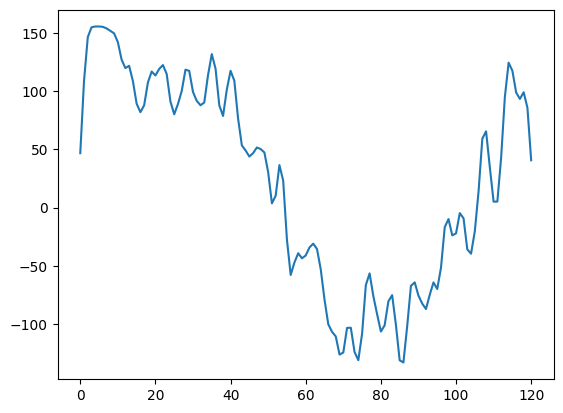

In [22]:
# plt.plot(state.best_member)
plt.plot(env.prepare_action(state.best_member))
plt.show()

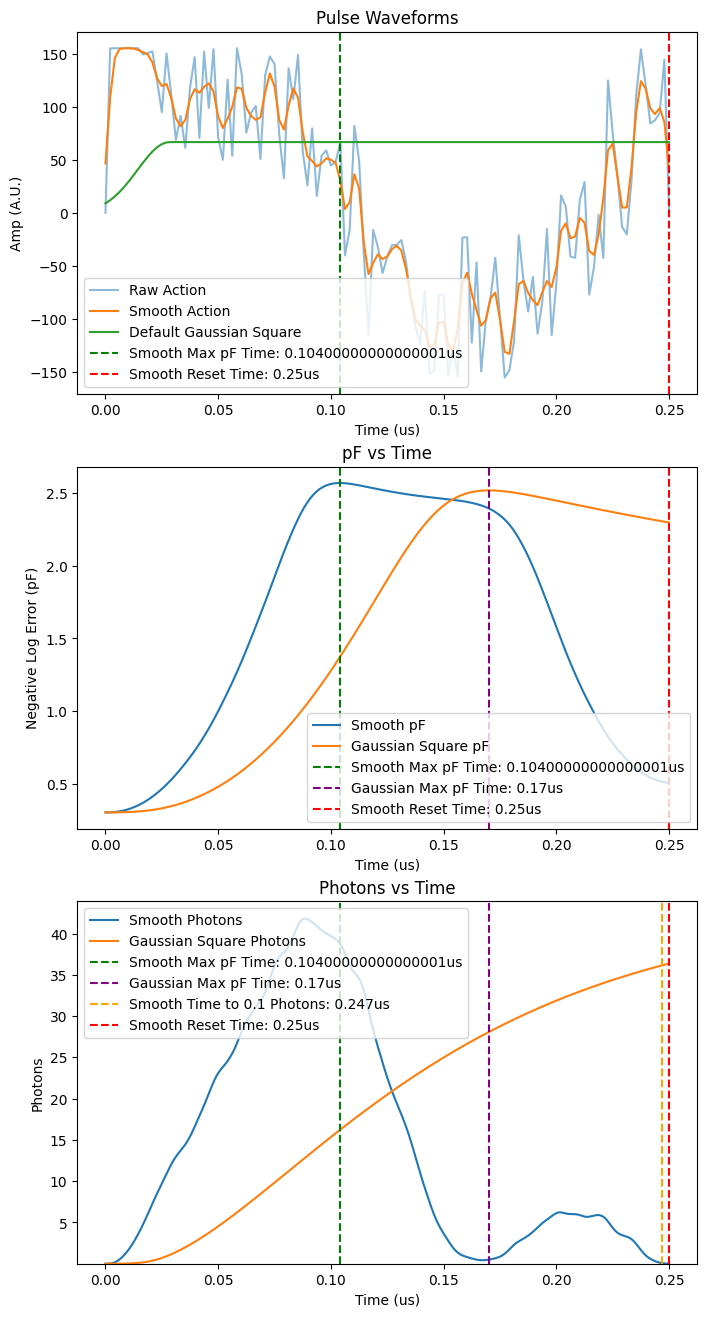

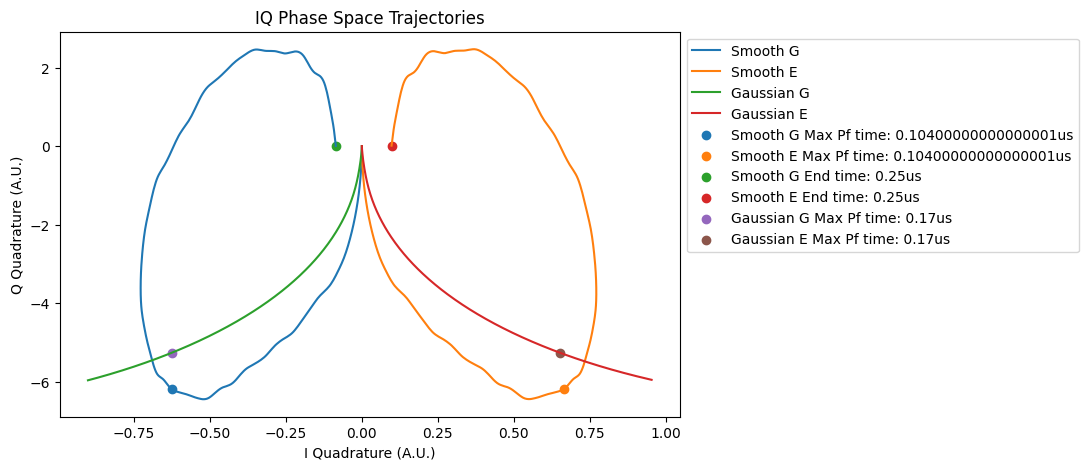

In [23]:
env.rollout_action(state.best_member)